In [3]:
import multiprocessing
import jieba
import nltk
import os
import time
from math import log
import json
import csv
import pandas as pd
import numpy as np

ModuleNotFoundError: No module named 'jieba'

In [1]:
tmp_catalog = '/Users/cecexu/Documents/cecexu/advertisement/cnews/'

In [2]:
feeds_file = tmp_catalog + 'douyin_ad.csv'

In [4]:
all_ads = tmp_catalog + 'all_ads.csv'

In [5]:
stopwords_file = tmp_catalog + 'stopwords1893.txt'

In [6]:
#read stop words
def read_stopwords(filepath):
    stopwords = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f.readlines():
            stopwords.append(line.strip())
    return stopwords

In [7]:
stopwords_list = read_stopwords(stopwords_file)

In [59]:
stopwords_list 

['!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '--',
 '.',
 '..',
 '...',
 '......',
 '...................',
 './',
 '.一',
 '.数',
 '.日',
 '/',
 '//',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 '://',
 '::',
 ';',
 '<',
 '=',
 '>',
 '>>',
 '?',
 '@',
 'A',
 'Lex',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'exp',
 'sub',
 'sup',
 '|',
 '}',
 '~',
 '~~~~',
 '·',
 '×',
 '×××',
 'Δ',
 'Ψ',
 'γ',
 'μ',
 'φ',
 'φ．',
 'В',
 '—',
 '——',
 '———',
 '‘',
 '’',
 '’‘',
 '“',
 '”',
 '”，',
 '…',
 '……',
 '…………………………………………………③',
 '′∈',
 '′｜',
 '℃',
 'Ⅲ',
 '↑',
 '→',
 '∈［',
 '∪φ∈',
 '≈',
 '①',
 '②',
 '②ｃ',
 '③',
 '③］',
 '④',
 '⑤',
 '⑥',
 '⑦',
 '⑧',
 '⑨',
 '⑩',
 '──',
 '■',
 '▲',
 '',
 '、',
 '。',
 '〈',
 '〉',
 '《',
 '》',
 '》），',
 '」',
 '『',
 '』',
 '【',
 '】',
 '〔',
 '〕',
 '〕〔',
 '㈧',
 '一',
 '一.',
 '一一',
 '一下',
 '一个',
 '一些',
 '一何',
 '一切',
 '一则',
 '一则通过',
 '一天',
 '一定',
 '一方面',
 '一旦',
 '一时',
 '一来',
 '一样',
 '一次',
 '一片',
 '一番',
 '一直',
 '一致',
 '一般',
 '一起',
 '一转眼'

In [8]:
#seperate sentence
def seg_sentence(sentence, stopwords):
    sentence_seged = jieba.cut(sentence.strip())
    outstr = ''
    for word in sentence_seged:
        if word not in stopwords:
            if word != '\t':
                outstr += word
                outstr += ' '
    return outstr

In [9]:
#read class and description from original dataset, and delete duplicate rows
from collections import defaultdict
account = []
def read_file(filename):
    outfile = []
    with open(filename, 'r', encoding='utf-8') as f:
        f_reader = csv.reader(f,delimiter = ',')
        next(f_reader, None)
        for line in f_reader:
            if line[1] not in account:
                account.append(line[1])
                outfile.append([line[0],line[1], line[2]])
            else:
                outfile.append([line[0],line[1], line[2]])
        outfile = pd.DataFrame(outfile)
    return outfile

In [10]:
out_feeds_df = read_file(feeds_file)

In [11]:
out_feeds_df.columns = ['class','account','desp']

In [12]:
out_feeds_df.head()

,class,account,desp
0,护肤美容,{痘博士},“一位痘友，一名顾问，一套方案”痘博士专业祛痘
1,护肤美容,{痘博士},如果你长痘还不会处理，那就预约痘博士祛痘套餐21.5
2,护肤美容,{痘博士},痘博士468祛痘套餐仅需21.5，每日仅限30名额
3,护肤美容,{痘博士},痘博士线上预约，线下体验，21.5体验面部祛痘套餐
4,护肤美容,{痘博士},分型祛痘，细致专业!21.5体验痘博士原价468元祛痘套餐


In [13]:
#read all ads
def read_file_ads(filename):
    outfile = []
    with open(filename, 'r') as f:
        f_reader = csv.reader(f,delimiter = ',')
        next(f_reader, None)
        for line in f_reader:
            if line[1] not in account:
                outfile.append([line[0],line[1]])
            else:
                outfile.append([line[0],line[1]])
        outfile = pd.DataFrame(outfile)
    return outfile

In [14]:
#read all ads
all_feeds_df = read_file_ads(all_ads)
all_feeds_df.columns = ['account','desp']

In [15]:
# split sentences and read label and corpus from classification data
def corpus_file(df):
    out_label = []
    out_corpus = []
    for i in range(len(df)):
        cut_words_act = seg_sentence(df['account'][i], stopwords_list)
        cut_words_desp = seg_sentence(df['desp'][i], stopwords_list)
        tmp = cut_words_act + cut_words_desp
        out_corpus.append([df['class'][i],df['account'][i], tmp])
    out_corpus = pd.DataFrame(out_corpus)
    return out_corpus

In [16]:
out_feeds_df.iloc[11815:11817]['desp']

11815    欧美爆款马丁靴，好穿不臭脚！支持货到付款！开箱试穿
11816    欧美爆款马丁靴！好穿不臭脚！支持货到付款！开箱试穿
Name: desp, dtype: object

In [17]:
seg_sentence(out_feeds_df.iloc[11815]['desp'], stopwords_list)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/6z/15w3r5bs0g5cc8frnnxvpv9m0000gp/T/jieba.cache
Loading model cost 0.813 seconds.
Prefix dict has been built succesfully.


'欧美 爆款 马丁 靴 穿 臭脚 支持 货到付款 开箱 试穿 '

In [18]:
seg_sentence(out_feeds_df.iloc[11816]['desp'], stopwords_list)

'欧美 爆款 马丁 靴 穿 臭脚 支持 货到付款 开箱 试穿 '

In [19]:
#generate corpus of samples and corpus of all data
corpus_df = corpus_file(out_feeds_df)

In [20]:
corpus_df.columns = ['class','account','desp']
corpus_df = corpus_df.drop_duplicates(subset=['class', 'desp'], keep=False)

In [21]:
corpus_df_1 = corpus_df[corpus_df['class']=='日用百货']
corpus_df_2 = corpus_df[corpus_df['class']=='旅游出行']

In [22]:
corpus_df = corpus_df.append(corpus_df_1)
corpus_df = corpus_df.append(corpus_df_1)
corpus_df = corpus_df.append(corpus_df_2)

In [23]:
corpus_df.groupby('class').count().reset_index()

,class,account,desp
0,家居家装,1578,1578
1,房地产,590,590
2,护肤美容,1009,1009
3,摄影,454,454
4,教育培训,1764,1764
5,文化娱乐,630,630
6,新闻,670,670
7,旅游出行,556,556
8,日用百货,567,567
9,服饰鞋包,367,367


In [24]:
def all_corpus_file(df):
    out_label = []
    out_corpus = []
    for i in range(len(df)):
        cut_words_act = seg_sentence(df['account'][i], stopwords_list)
        cut_words_desp = seg_sentence(df['desp'][i], stopwords_list)
        tmp = cut_words_act + cut_words_desp
        out_corpus.append([df['account'][i], tmp])    
    out_corpus = pd.DataFrame(out_corpus)
    return out_corpus

In [25]:
all_corpus_df = all_corpus_file(all_feeds_df)

In [26]:
all_corpus_df.columns = ['account','desp']
all_corpus_df = all_corpus_df.drop_duplicates(subset=['desp'], keep=False)

In [27]:
all_corpus_df.head()

,account,desp
7,{痘博士},痘 博士 告诉 秘密 领券后 买 衣服 不到 50 太值
8,{痘博士},痘 博士 领券后 下单 每套 衣服 不到 50 元
9,{痘博士},痘 博士 同事 新 衣服 买 领完券 一套 不到 50 元
10,{痘博士},痘 博士 告诉 秘密 领券后 买 衣服 50 元 太值
11,{痘博士},痘 博士 同事 衣服 买 一套 50 元 超 划算


In [28]:
#merge sample data and all data
tmp_corpus_df = pd.merge(corpus_df, all_corpus_df, on = ['account','desp'], how = 'outer')

In [29]:
len(corpus_df)

17671

In [30]:
len(tmp_corpus_df.loc[tmp_corpus_df['account'] == '诛魔长生劫'])

109

In [31]:
#calculate tf-idf of the whole dataset
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df = 1e-5) #drop df <1e-5, low frequency words
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(vectorizer.fit_transform(tmp_corpus_df['desp']))
words = vectorizer.get_feature_names()
print(tfidf.toarray())
print(tfidf.shape[0], tfidf.shape[1])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
65971 45060


In [32]:
#select tfidf matrix of data with unknown classes 
rest_corpus_df = tmp_corpus_df[tmp_corpus_df['class'].isnull()]
rest_tfidf = tfidf[rest_corpus_df.index.values]

In [33]:
rest_corpus_df.index.values

array([17671, 17672, 17673, ..., 65968, 65969, 65970])

In [34]:
#select tfidf matrix of sample data
clas_corpus_df = tmp_corpus_df.dropna(axis = 0)
clas_tfidf = tfidf[clas_corpus_df.index.values]

In [35]:
len(clas_corpus_df)

17671

In [36]:
clas_corpus_df.head()

,class,account,desp
0,护肤美容,{痘博士},痘 博士 一位 痘友 一名 顾问 一套 方案 痘 博士 专业 祛痘
1,护肤美容,{痘博士},痘 博士 长 痘 预约 痘 博士 祛痘 套餐 21.5
2,护肤美容,{痘博士},痘 博士 痘 博士 468 祛痘 套餐 需 21.5 每日 仅限 30 名额
3,护肤美容,{痘博士},痘 博士 痘 博士 线上 预约 线下 体验 21.5 体验 面部 祛痘 套餐
4,护肤美容,{痘博士},痘 博士 分型 祛痘 细致 专业 21.5 体验 痘 博士 原价 468 元 祛痘 套餐


In [37]:
#encode labels
from sklearn import preprocessing
clas_corpus = list(clas_corpus_df['desp'])
clas_label = list(clas_corpus_df['class'])
clas_account = list(clas_corpus_df['account'])
all_account = list(tmp_corpus_df['account'])
encoder = preprocessing.LabelEncoder()
encoder_label = encoder.fit_transform(clas_label) 

In [38]:
len(clas_corpus)

17671

In [39]:
# #split data to train, and test datasets
# np.random.seed(100)
# test_ratio = 0.1
# shuffle_index = np.random.permutation(len(clas_label))
# test_set_size=int(len(clas_label)*test_ratio)
# test_indices =shuffle_index[:test_set_size]
# train_indices =shuffle_index[test_set_size:]

In [40]:
def train_validate_test_split(dataset, train_test_percent, valid_percent, seed=None):
    np.random.seed(seed)
    m = len(dataset)
    shuffle_index = np.random.permutation(m)
    train_test_size = int(train_test_percent * m)
    train_test_index = shuffle_index[:train_test_size]
    valid_index = shuffle_index[train_test_size:]
    return train_test_index, valid_index

In [41]:
train_test_idx, valid_idx = train_validate_test_split(clas_label, 0.9, 0.1, seed=None)
train_test_tfidf = clas_tfidf[train_test_idx]
valid_tfidf = clas_tfidf[valid_idx]
# train_label = encoder_label[train_indices]
# test_label = encoder_label[test_indices]
train_test_label = [clas_label[i] for i in train_test_idx]
valid_label = [clas_label[i] for i in valid_idx]
train_test_account = [clas_account[i] for i in train_test_idx]
valid_account = [clas_account[i] for i in valid_idx]

In [42]:
max(valid_idx)

17663

In [61]:
#split model data and validation data on LogisticRegression
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
n_samples = len(train_test_label)
lr_model = LogisticRegression()
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val_score(lr_model, train_test_tfidf, train_test_label, cv=cv)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


array([0.98805407, 0.99119774, 0.9924552 , 0.98899717, 0.9915121 ])

In [44]:
#logistic regression
#lr_model = LogisticRegression()
lr_model.fit(train_test_tfidf, train_test_label)
y_pred_lr_valid = lr_model.predict(valid_tfidf)
print(classification_report(valid_label, y_pred_lr_valid))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

        家居家装       1.00      1.00      1.00       171
         房地产       1.00      1.00      1.00        40
        护肤美容       1.00      0.96      0.98       110
          摄影       1.00      1.00      1.00        48
        教育培训       0.99      0.99      0.99       160
        文化娱乐       1.00      0.98      0.99        66
          新闻       1.00      1.00      1.00        81
        旅游出行       1.00      0.98      0.99        56
        日用百货       1.00      1.00      1.00        61
        服饰鞋包       1.00      0.93      0.96        42
          汽车       0.99      0.99      0.99        75
          游戏       1.00      1.00      1.00        78
        珠宝腕表       0.99      1.00      0.99        97
        生活服务       1.00      0.98      0.99        89
          社交       1.00      0.99      0.99        91
        综合电商       0.94      1.00      0.97       241
        视频音频       1.00      0.98      0.99        65
        运动健身       1.00    

In [45]:
from sklearn.metrics import accuracy_score
print(accuracy_score(valid_label, y_pred_lr_valid))

0.9892533936651584


In [46]:
#random forest
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators = 200, random_state = 1800)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val_score(rf_model, train_test_tfidf, train_test_label, cv=cv) 

array([0.9933983 , 0.9962276 , 0.9971707 , 0.99559887, 0.99654197])

In [47]:
rf_model.fit(train_test_tfidf, train_test_label)
y_pred_rf_valid = rf_model.predict(valid_tfidf)
print(classification_report(valid_label, y_pred_rf_valid))

              precision    recall  f1-score   support

        家居家装       0.99      0.99      0.99       171
         房地产       1.00      1.00      1.00        40
        护肤美容       0.97      1.00      0.99       110
          摄影       1.00      1.00      1.00        48
        教育培训       1.00      1.00      1.00       160
        文化娱乐       1.00      0.98      0.99        66
          新闻       1.00      1.00      1.00        81
        旅游出行       1.00      1.00      1.00        56
        日用百货       1.00      1.00      1.00        61
        服饰鞋包       1.00      0.98      0.99        42
          汽车       1.00      1.00      1.00        75
          游戏       1.00      1.00      1.00        78
        珠宝腕表       0.99      1.00      0.99        97
        生活服务       1.00      0.98      0.99        89
          社交       0.99      1.00      0.99        91
        综合电商       1.00      1.00      1.00       241
        视频音频       1.00      0.98      0.99        65
        运动健身       1.00    

In [48]:
from sklearn.metrics import accuracy_score
print(accuracy_score(valid_label, y_pred_rf_valid))

0.9960407239819005


In [49]:
#compare predicted label with actual label after classification
tmp = defaultdict(list)
test_tmp = defaultdict(list)
pred_tmp = defaultdict(list)

for i, v in enumerate(y_pred_rf_valid): 
    x = rf_model.predict_proba(valid_tfidf[i])
    pred_tmp[valid_account[i]].append([v, np.amax(x)])
    if valid_label[i] != v:
        tmp[valid_account[i]].append((v, valid_label[i]))
        x = rf_model.predict_proba(valid_tfidf[i])
    else:
        test_tmp[valid_account[i]].append(v)

In [50]:
#predict to all data
y_pred_rf = rf_model.predict(tfidf)

In [52]:
for i, v in enumerate(y_pred_rf): 
    x = rf_model.predict_proba(tfidf[i])
    pred_tmp[all_account[i]].append([v, np.amax(x)])

In [53]:
pred_tmp['车置宝-高价收车']

[['汽车', 0.89],
 ['汽车', 0.72],
 ['汽车', 0.955],
 ['汽车', 0.83],
 ['汽车', 0.775],
 ['汽车', 0.775],
 ['汽车', 0.89],
 ['汽车', 0.96],
 ['汽车', 0.92],
 ['汽车', 0.72],
 ['汽车', 0.89],
 ['汽车', 0.96],
 ['汽车', 0.94],
 ['汽车', 0.6],
 ['汽车', 0.89],
 ['汽车', 0.95],
 ['汽车', 0.88],
 ['汽车', 0.72],
 ['汽车', 0.72],
 ['汽车', 0.75],
 ['汽车', 0.775],
 ['汽车', 0.805],
 ['汽车', 0.705],
 ['汽车', 0.82],
 ['汽车', 0.895],
 ['汽车', 0.905],
 ['汽车', 0.875],
 ['汽车', 0.965],
 ['汽车', 0.88],
 ['汽车', 0.885],
 ['汽车', 0.805],
 ['汽车', 0.86],
 ['汽车', 0.855],
 ['汽车', 0.915],
 ['汽车', 0.845],
 ['汽车', 0.815],
 ['汽车', 0.505],
 ['汽车', 0.77],
 ['汽车', 0.775],
 ['汽车', 0.91],
 ['汽车', 0.72],
 ['汽车', 0.81],
 ['汽车', 0.85],
 ['汽车', 0.815],
 ['汽车', 0.705],
 ['汽车', 0.95],
 ['汽车', 0.815],
 ['汽车', 0.675],
 ['汽车', 0.815],
 ['汽车', 0.945],
 ['汽车', 0.895],
 ['汽车', 0.88],
 ['汽车', 0.51],
 ['汽车', 0.9],
 ['汽车', 0.95],
 ['珠宝腕表', 0.61],
 ['汽车', 0.955],
 ['汽车', 0.83],
 ['汽车', 0.775],
 ['汽车', 0.775],
 ['汽车', 0.89],
 ['汽车', 0.96],
 ['汽车', 0.92],
 ['汽车', 0.72],
 ['汽车', 0.89

In [54]:
# #classes validation of accounts
# from collections import Counter
# account = {}
# for k, v in pred_tmp.items():
#     ac = []
#     for n in v:
#         ac.append(n[0])
#     if len(set(ac)) == 1:
#         account[k] = v[0][0]
#     else:
#         x = Counter(ac)
#         x_max = max(x.values())
#         keys = [k for k, v in x.items() if v == x_max]
#         if len(keys) == 1:
#             account[k] = keys[0]
#         else:
#             v = pd.DataFrame(v)
#             df_v = v[v[0].isin(keys)]
#             max_df = df_v.groupby(0)[1].max().reset_index(name = 'value')
#             max_key = max_df[max_df['value'] == max_df['value'].max()].iloc[0][0]
#             account[k] = max_key      

In [55]:
from collections import Counter
account = defaultdict(list)
for k, v in pred_tmp.items():
    ac = []
    for n in v:
        ac.append(n[0])
    if len(set(ac)) == 1:
        account[v[0][0]].append(k)
    else:
        x = Counter(ac)
        x_max = max(x.values())
        keys = [k for k, v in x.items() if v == x_max]
        if len(keys) == 1:
            account[keys[0]].append(k)
        else:
            v = pd.DataFrame(v)
            df_v = v[v[0].isin(keys)]
            max_df = df_v.groupby(0)[1].max().reset_index(name = 'value')
            max_key = max_df[max_df['value'] == max_df['value'].max()].iloc[0][0]
            account[max_key].append(k)   

In [56]:
tmp_corpus_df[tmp_corpus_df['account'] == '沙力科技']

,class,account,desp
6788,汽车,沙力科技,沙力 科技 买 新车 拍 不到 沪牌 一步到位 拍牌 中 付款
6789,汽车,沙力科技,沙力 科技 代拍 行业 真实 命中率 我来 教
6790,汽车,沙力科技,沙力 科技 上海 拍 车牌 看过 选择 迟
6791,汽车,沙力科技,沙力 科技 新车 锈了 拍到 沪 牌 找 帮 快速 拿牌
6792,汽车,沙力科技,沙力 科技 通知 拍牌 难 拍牌 中 高额 赔偿
6793,汽车,沙力科技,沙力 科技 沪 牌代 拍 沪牌 越来越 难 拍 拍牌 新 攻略
6794,汽车,沙力科技,沙力 科技 新车 生锈 拍到 沪 牌 找 帮 快速 拿牌
6795,汽车,沙力科技,沙力 科技 上海 随时随地 开车 全靠 一张 沪牌 一步到位 拍牌


In [57]:
import matplotlib.pyplot as plt
clas_dict = {}
for i, v in account.items():
    clas_dict[i] = len(v)

s = dict([(k, clas_dict[k]) for k in sorted(clas_dict, key=clas_dict.get, reverse=True)])

In [ ]:
account

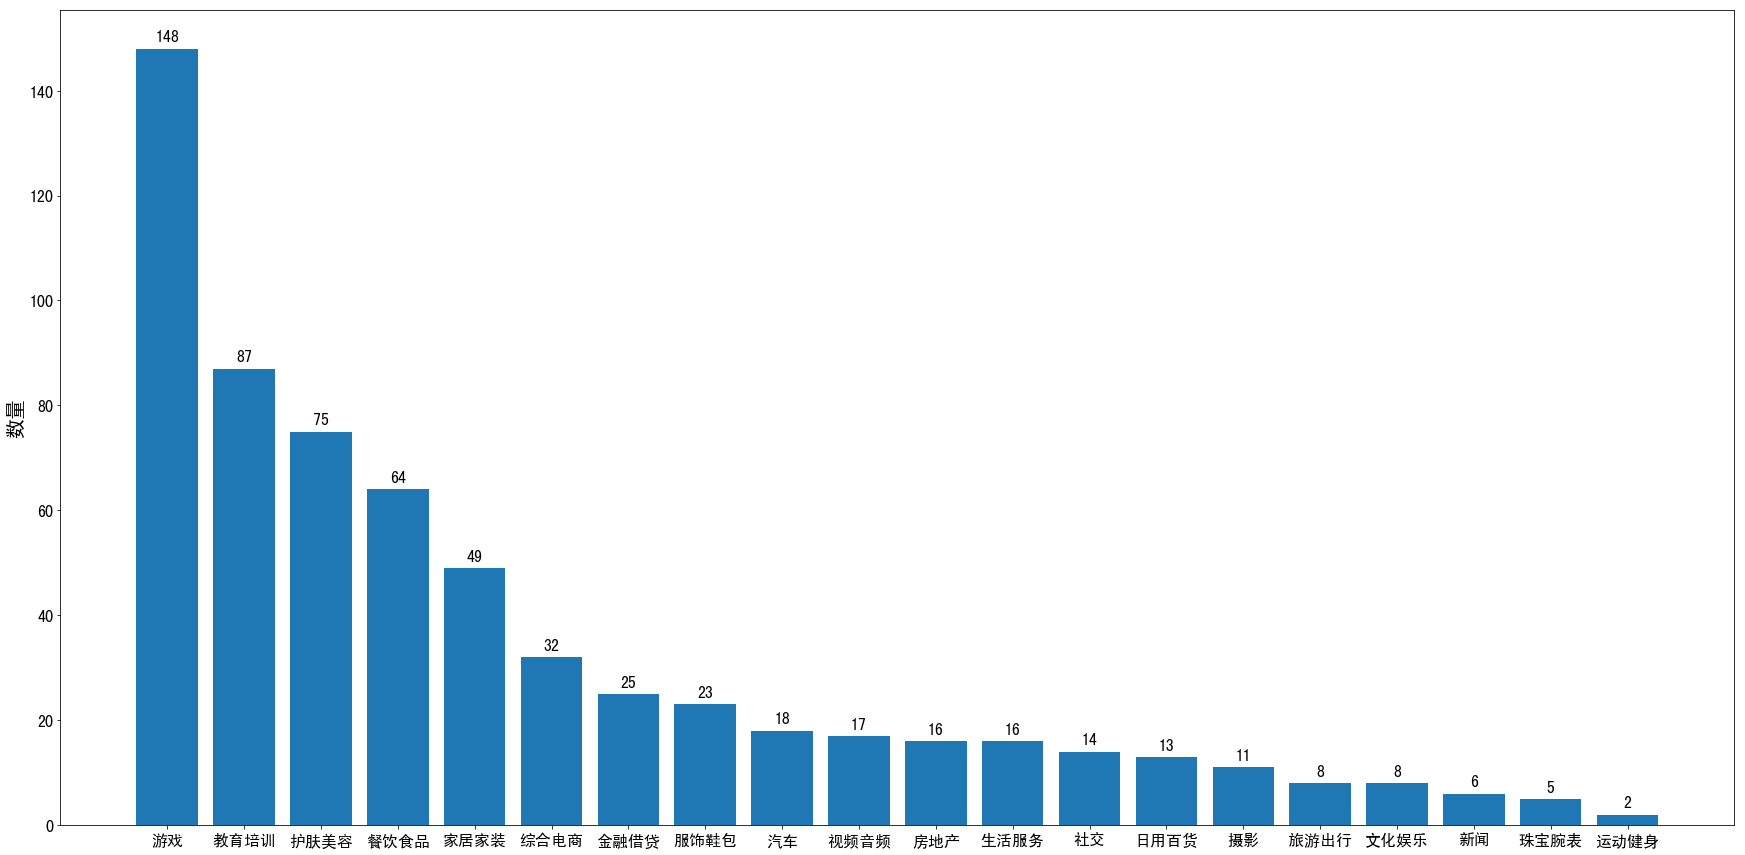

In [58]:
from pylab import * 
from matplotlib.font_manager import _rebuild
_rebuild() 
mpl.rcParams['font.family']='sans-serif'
mpl.rcParams['font.sans-serif']=[u'SimHei']
x_name = ['教育培训', '综合电商', '汽车', '金融借贷', '视频音频', '新闻', '护肤美容', '家居家装', '餐饮食品', '运动健身', \
          '珠宝腕表', '生活服务', '房地产', '文化娱乐', '旅游出行', '社交', '服饰鞋包', '日用百货', '摄影', '游戏'] 
plt.figure(figsize=(30,15))
plt.bar(list(s.keys()),list(s.values()))
plt.xticks(x_name, fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylabel('数量', fontsize = 20)
for k,v in s.items():
    plt.text(k, v+1, '%.0f' % v, ha='center', va= 'bottom',fontsize=16)

In [ ]:
t = pred_tmp[pred_tmp['account'].isin(tmp.keys())].groupby(['account','class'])\
['class'].count().reset_index(name = 'cnt')

In [ ]:
s.keys()

In [262]:
np.savetxt('all_corpus.txt', all_corpus, delimiter=',', fmt='%s', header = 'desp', comments='')
#construct a new corpus 
#new_corpus = pd.read_table(tmp_catalog + 'all_corpus.txt', sep = ',')